In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['imdbraw', 'glove-global-vectors-for-word-representation', 'imdb-data']


### Questão 01

#### GloVe

In [2]:
imdb_dir = '../input/imdbraw/aclimdb/aclImdb/'
train_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


In [3]:
maxlen = 100 # Cuts off reviews after 100 words
training_samples = 5000 # Trains on 200 samples
validation_samples = 10000 # Validates on 10,000 samples
max_words = 10000 # Considers only the top 10,000 words in the dataset

In [4]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [5]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 72633 unique tokens.


In [6]:
data = pad_sequences(sequences, maxlen=maxlen)

In [7]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (17243, 100)
Shape of label tensor: (17243,)


In [8]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [9]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [10]:
glove_dir = '../input/glove-global-vectors-for-word-representation/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [11]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector #Words not found in the embedding index will be all zeros.

In [12]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [14]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=30,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 2s 376us/step - loss: 0.6439 - acc: 0.7030 - val_loss: 0.5422 - val_acc: 0.7351
Epoch 2/30
5000/5000 [==============================] - 1s 214us/step - loss: 0.4984 - acc: 0.7702 - val_loss: 0.5158 - val_acc: 0.7544
Epoch 3/30
5000/5000 [==============================] - 1s 216us/step - loss: 0.4102 - acc: 0.8158 - val_loss: 1.3007 - val_acc: 0.3659
Epoch 4/30
5000/5000 [==============================] - 1s 215us/step - loss: 0.3424 - acc: 0.8504 - val_loss: 0.8554 - val_acc: 0.7423
Epoch 5/30
5000/5000 [==============================] - 1s 213us/step - loss: 0.2910 - acc: 0.8800 - val_loss: 1.6085 - val_acc: 0.4052
Epoch 6/30
5000/5000 [==============================] - 1s 215us/step - loss: 0.2285 - acc: 0.9098 - val_loss: 0.8178 - val_acc: 0.7506
Epoch 7/30
5000/5000 [==============================] - 1s 216us/step - loss: 0.1925 - acc: 0.9212 - val_loss: 0.6813 - val_acc: 0.7295

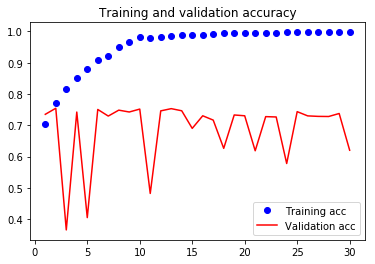

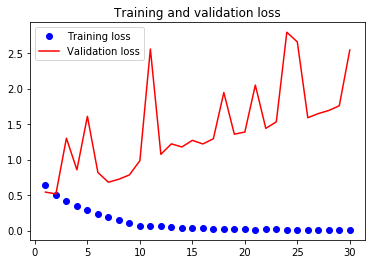

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Embedding

In [16]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=30,
batch_size=32,
validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 2s 337us/step - loss: 0.5077 - acc: 0.7492 - val_loss: 0.3910 - val_acc: 0.8371
Epoch 2/30
5000/5000 [==============================] - 1s 254us/step - loss: 0

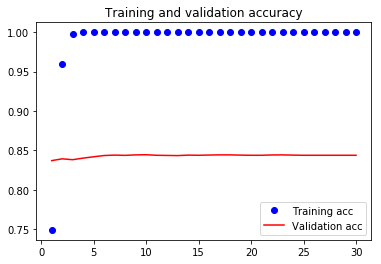

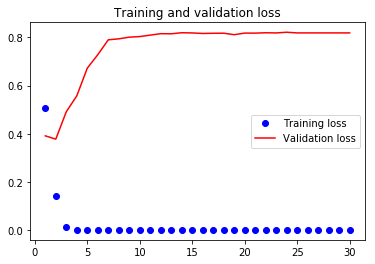

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Questão 02

#### GloVe

In [18]:
dropout = [0.3,0.4,0.5]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 60s 12ms/step - loss: 0.5820 - acc: 0.7220 - val_loss: 0.5639 - val_acc: 0.7430
Epoch 2/30
5000/5000 [==============================] - 58s 12ms/step - loss: 0.5544 - acc: 0.7308 - val_loss: 0.5143 - val_acc: 0.7472
Epoch 3/30
5000/5000 [==============================] - 58s 12ms/step - los

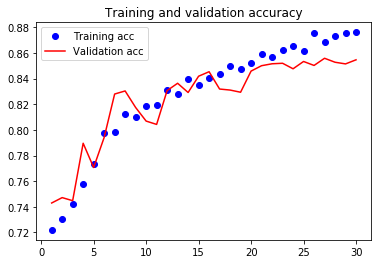

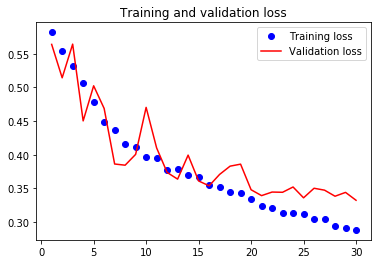

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 60s 12ms/step - loss: 0.5916 - acc: 0.7128 - val_loss: 0.5704 - val_acc: 0.7283
Epoch 2/30
5000/5000 [==============================] - 58s 12ms/step - loss: 0.5678 - acc: 0.7230 - val_loss: 0.5527 - val_acc: 0.7350
Epoch 3/30
5000/5000 [==============================] - 59s 12ms/step - los

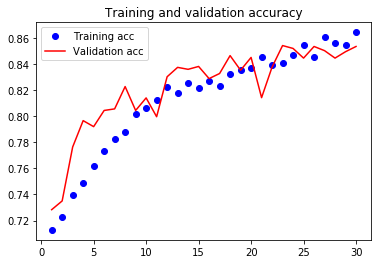

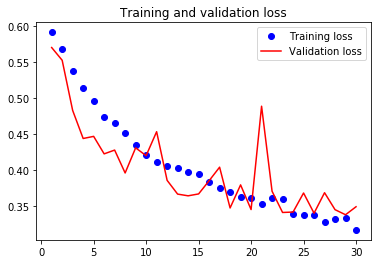

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 60s 12ms/step - loss: 0.5947 - acc: 0.7138 - val_loss: 0.5637 - val_acc: 0.7292
Epoch 2/30
5000/5000 [==============================] - 59s 12ms/step - loss: 0.5742 - acc: 0.7212 - val_loss: 0.5636 - val_acc: 0.7293
Epoch 3/30
5000/5000 [==============================] - 59s 12ms/step - los

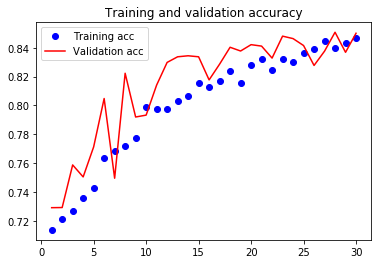

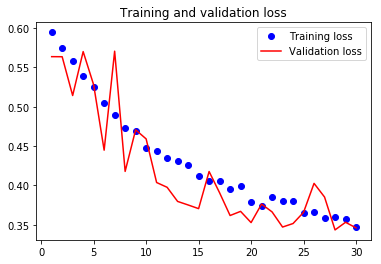

In [19]:
for drop in dropout:
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(LSTM(32,dropout=drop))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    
    model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])

    history = model.fit(x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val))
    model.save_weights('pre_trained_glove_model.h5')
    
    print('Dropout: ',drop)
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

#### Embedding

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 64s 13ms/step - loss: 0.5158 - acc: 0.7514 - val_loss: 0.3948 - val_acc: 0.8252
Epoch 2/30
5000/5000 [==============================] - 63s 13ms/step - loss: 0.3091 - acc: 0.8784 - val_loss: 0.3488 - val_acc: 0.8396
Epoch 3/30
5000/5000 [==============================] - 62s 12ms/step - los

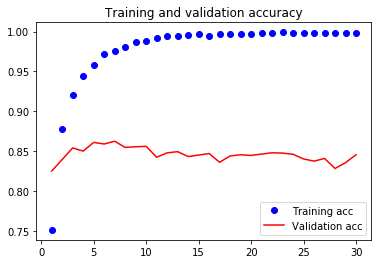

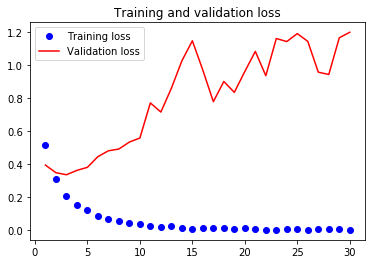

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 63s 13ms/step - loss: 0.5317 - acc: 0.7372 - val_loss: 0.4243 - val_acc: 0.8020
Epoch 2/30
5000/5000 [==============================] - 61s 12ms/step - loss: 0.3403 - acc: 0.8646 - val_loss: 0.3613 - val_acc: 0.8439
Epoch 3/30
5000/5000 [==============================] - 61s 12ms/step - los

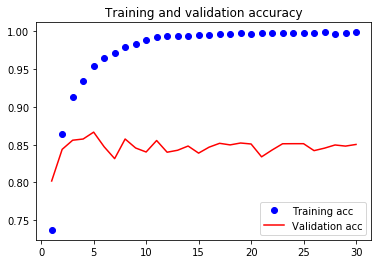

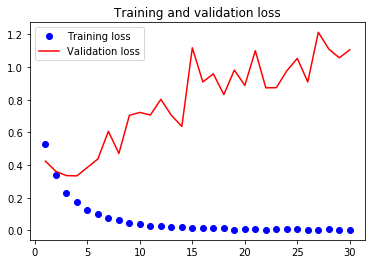

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 64s 13ms/step - loss: 0.5301 - acc: 0.7388 - val_loss: 0.4555 - val_acc: 0.7793
Epoch 2/30
5000/5000 [==============================] - 61s 12ms/step - loss: 0.3544 - acc: 0.8552 - val_loss: 0.3660 - val_acc: 0.8432
Epoch 3/30
5000/5000 [==============================] - 61s 12ms/step - los

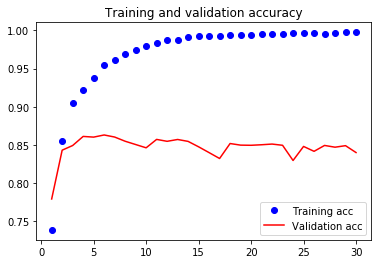

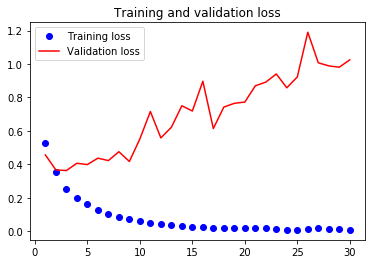

In [20]:
for drop in dropout:
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(LSTM(32,dropout=drop))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])
    history = model.fit(x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val))
    
    print('Dropout: ',drop)
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

### Questão 03

#### GloVe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 1,034,113
Trainable params: 1,034,113
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 112s 22ms/step - loss: 0.5673 - acc: 0.7242 - val_loss: 0.5059 - val_acc: 0.7385
Epoch 2/30
5000/5000 [==============================] - 111s 22ms/step - loss: 0.4848 - acc: 0.7644 - val_loss: 0.6394 - val_acc: 0.6143
Epoch 3/30
5000/5000 [==============================] - 112s 22ms/step - 

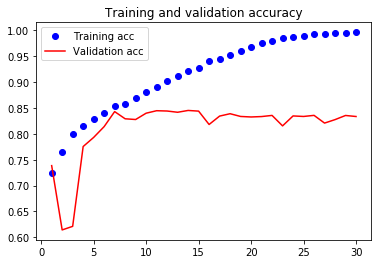

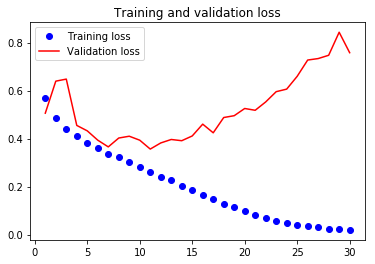

In [21]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=30,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Embedding

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,034,113
Trainable params: 1,034,113
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/30
5000/5000 [==============================] - 118s 24ms/step - loss: 0.5054 - acc: 0.7518 - val_loss: 0.4034 - val_acc: 0.8187
Epoch 2/30
5000/5000 [==============================] - 115s 23ms/step - loss: 0.2674 - acc: 0.8908 - val_loss: 0.3766 - val_acc: 0.8530
Epoch 3/30
5000/5000 [==============================] - 114s 23ms/step - 

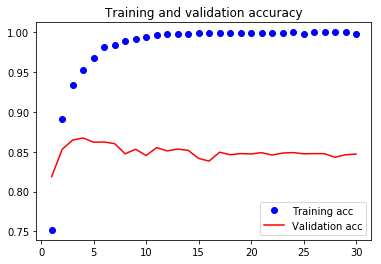

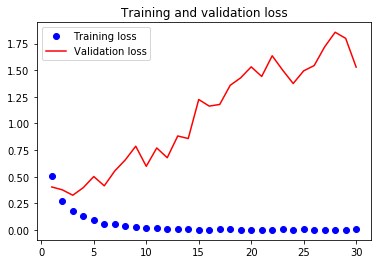

In [22]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=30,
batch_size=32,
validation_data=(x_val, y_val))

print('Dropout: ',drop)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()